# 2013_spiking_STDP

这里的dynamics是在con而不是在synaptic variable "s"

In [1]:
from brian2 import *
%matplotlib inline
import numpy as np

# parameter

In [2]:
k=200
NE=4*k
NI=1*k
NO=5*k


########time constant#######
#for each neuron
TE=20*ms
TI=10*ms


#for synaptic variable(including NMDA and AMPA)
TEI=TII=5*ms
TEE_N=150*ms
TEE_A=50*ms
TIE_N=45*ms
TIE_A=20*ms
TEO=100*ms

#proba
rou=0.1
#strength(大小，最终还有正负号) 且用数目和概率做一个scaling
JEE=JIE=10/sqrt(NE*rou)*2
JEI=JII=15/sqrt(NI*rou)*2
JEO=100/sqrt(NO*rou)
#strength test(not balanced)
# JEE=100/sqrt(NE*rou)
# JIE=200/sqrt(NE*rou)
# JEI=200/sqrt(NI*rou)
# JII=100/sqrt(NI*rou)
# JEO=100/sqrt(NO*rou)



#proportion of NMDA and AMPA
q_EE_N=0.5
q_EE_A=0.5
q_IE_N=0.2
q_IE_A=0.8

# Neurons

In [3]:
eqs='''
dv/dt=(-v+J_E*(q*con_E_N+(1-q)*con_E_A) - J_I*con_I + J_O*con_O)/tau_neuron:1 (unless refractory)
dcon_E_N/dt = -con_E_N/tau_E_N :1 
dcon_E_A/dt = -con_E_A/tau_E_A :1 
dcon_I/dt = -con_I/tau_I :1
dcon_O/dt = -con_O/tau_O :1
q:1
J_E:1
J_I:1
J_O:1
tau_E_A:second
tau_E_N:second
tau_I:second
tau_O:second
tau_neuron:second
'''
#define all neurons in one group
G=NeuronGroup(NE+NI,eqs,threshold="v>1",reset="v=0",refractory=2*ms, method='exact')

G_E=G[:int(NE)]
G_I=G[int(NE):]

#parameters:
G.tau_neuron[0:int(NE)] = TE
G.tau_neuron[int(NE):] = TI
G.tau_E_N[0:int(NE)] = TEE_N
G.tau_E_N[int(NE):] = TIE_N
G.tau_E_A[0:int(NE)] = TEE_A
G.tau_E_A[int(NE):] = TIE_A
G.tau_I[0:int(NE)] = TEI
G.tau_I[int(NE):] = TII
G.tau_O[0:int(NE)] = TEO
G.tau_O[int(NE):] = 1*ms #这里随意，反正I的con_O一直是0
G.q[0:int(NE)] = q_EE_N
G.q[int(NE):] = q_IE_N
G.J_E[0:int(NE)] = JEE
G.J_E[int(NE):] = JIE
G.J_I[0:int(NE)] = JEI
G.J_I[int(NE):] = JII
G.J_O[0:int(NE)] = JEO
G.J_O[int(NE):] = 0
#Initial values:
G.v[:]=[uniform(0,1) for i in range(NI+NE)]




# Synapses

In [4]:
#Plsticity parameters
t_forw = 15*ms
t_back = 20*ms
# A_forw = 7e-3
# A_back = A_forw * t_forw/t_back
#equations for synapses from inhibitory neurons
eqs_I='''
w:1
do_j1/dt  = -o_j1/t_forw   : 1 (event-driven)
do_i1/dt  = -o_i1/t_back  : 1 (event-driven)
do_j/dt   = (o_j1 - o_j)/t_forw  : 1 (event-driven) 
do_i/dt   = (o_i1 - o_i)/t_back : 1 (event-driven) 
'''
#equations for synapses from inhibitory neurons
#q是N的含量
eqs_E='''
w_N:1
w_A:1
do_j1/dt  = -o_j1/t_forw   : 1 (event-driven)
do_i1/dt  = -o_i1/t_back  : 1 (event-driven)
do_j/dt   = (o_j1 - o_j)/t_forw  : 1 (event-driven) 
do_i/dt   = (o_i1 - o_i)/t_back : 1 (event-driven) 
'''

update_I_pre='''
con_I_post+=w
w += - o_i * A_back
o_j1+= 1
'''
update_E_pre='''
con_E_N_post+=w_N
con_E_A_post+=w_A
w_N += o_i * A_back
w_A += o_i * A_back
o_j1+= 1
'''
update_I_post='''
w += o_j * A_forw
o_i1+=1
'''
update_E_post='''
w_N += - o_j * A_forw
w_A += - o_j * A_forw
o_i1+=1
'''

syn_EI=Synapses(G_I,G_E,eqs_I,on_pre=update_I_pre,on_post=update_I_post,method="exact")
syn_II=Synapses(G_I,G_I,eqs_I,on_pre=update_I_pre,on_post=update_I_post,method="exact")
syn_IE=Synapses(G_E,G_I,eqs_E,on_pre=update_E_pre,on_post=update_E_post,method="exact")
syn_EE=Synapses(G_E,G_E,eqs_E,on_pre=update_E_pre,on_post=update_E_post,method="exact")

#
syn_EI.connect(p=rou)
syn_II.connect(p=rou)
syn_IE.connect(p=rou)
syn_EE.connect(p=rou)

#注意：这里可能需要用N*P进行scale一下...不用scale!不能scale!(之前的con就是sum了)
syn_EI.w= 1/(TEI/ms)
syn_II.w= 1/(TII/ms)
syn_IE.w_N=1/(TIE_N/ms)
syn_IE.w_A=1/(TIE_A/ms)
syn_EE.w_N=1/(TEE_N/ms)
syn_EE.w_A=1/(TEE_A/ms)



net=Network(collect())

# Simulation

External Neuron

In [5]:
n_loop = 3
unit_time = 20*ms
sti_unit = 1
delay_unit = 8
sti_time = unit_time*sti_unit
delay_time = unit_time*delay_unit
sti_rate = 40*Hz

rate = []
for i in range(n_loop):
    for j in range(sti_unit):
        rate.append(sti_rate)
    for j in range(delay_unit):
        rate.append(0*Hz)
T = TimedArray(rate,dt = unit_time)
#总共specify了 n_loop*unit_time*(sti_unit+delay_unit)的时间的rate

In [6]:
###External neurons 只是连接到E上面###
P=PoissonGroup(NO,rates="T(t)")  #rates= 40Hz
#External input synapses:在simulation的时候加，一开始没有，然后加上去，然后再去掉external input
eqs_O='''
w:1
'''
syn_EO=Synapses(P,G_E,eqs_O,on_pre="con_O_post+=w",method="exact")
syn_EO.connect(p=rou)
#
# syn_EO.J=JEO
syn_EO.w=1/(TEO/ms)
# syn_EO.tau=TEO 
net.add(P)
net.add(syn_EO)

In [7]:
statemon_G = StateMonitor(G, 'v', record=True)
net.add(statemon_G)
spikemon_G=SpikeMonitor(G)
net.add(spikemon_G) 
#rate
ratemon_E = PopulationRateMonitor(G_E)
net.add(ratemon_E)
ratemon_I = PopulationRateMonitor(G_I)
net.add(ratemon_I)
ratemon_G = PopulationRateMonitor(G)
net.add(ratemon_G)
###for testing
statemon_G_con_I = StateMonitor(G, 'con_I', record=True)
statemon_G_con_E_N = StateMonitor(G, 'con_E_N', record=True)
statemon_G_con_E_A = StateMonitor(G, 'con_E_A', record=True)
statemon_G_con_O = StateMonitor(G, 'con_O', record=True)
net.add(statemon_G_con_I)
net.add(statemon_G_con_O)
net.add(statemon_G_con_E_N)
net.add(statemon_G_con_E_A)

In [8]:
for i in range(n_loop):
    #stimilus on, plasticity off
    A_forw = 0
    A_back = A_forw * t_forw/t_back
    net.run(unit_time*sti_unit)
    #stimilus off, plasticity on
    A_forw = 7e-3 #0
    A_back = A_forw * t_forw/t_back
    net.run(unit_time*delay_unit)
    #reset
    G.v[:]=[uniform(0,1) for i in range(NI+NE)]
    G.con_E_A = 0
    G.con_E_N =0
    G.con_I =0
    G.con_O =0

# plot

INFO       width adjusted from 2. ms to 2.1 ms [brian2.monitors.ratemonitor.adjusted_width]


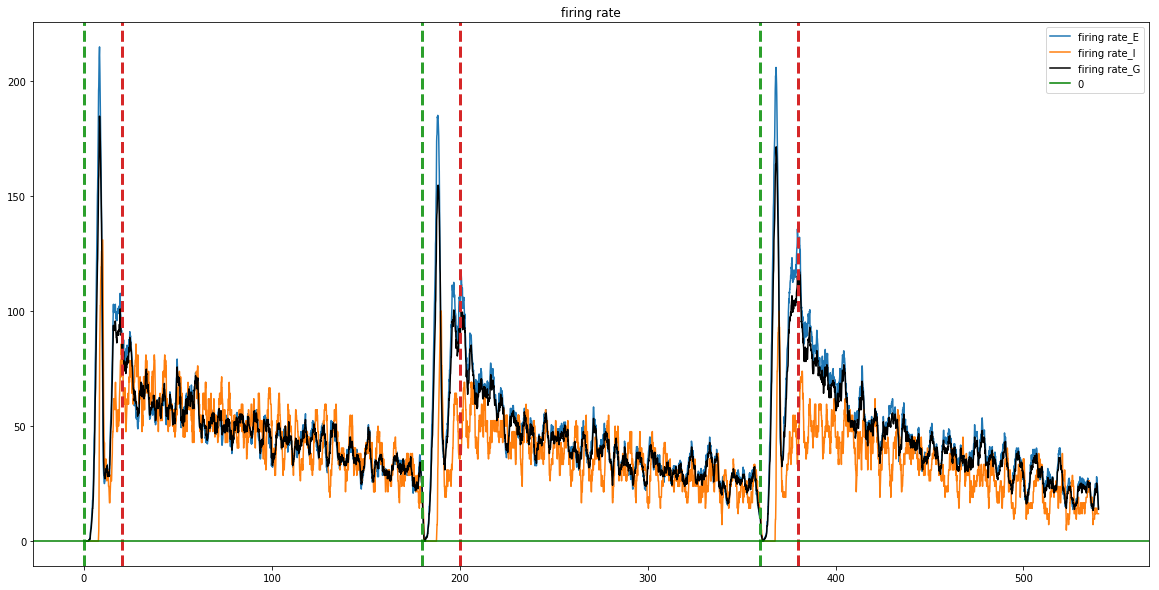

In [9]:
#firing rate
figure(figsize=(20,10))
plot(ratemon_E.t/ms,ratemon_E.smooth_rate(window='flat', width=2*ms)/Hz,label="firing rate_E")
plot(ratemon_I.t/ms,ratemon_I.smooth_rate(window='flat', width=2*ms)/Hz,label="firing rate_I")
plot(ratemon_G.t/ms,ratemon_G.smooth_rate(window='flat', width=2*ms)/Hz,c="k",label="firing rate_G")
# axhline(y=500,color="r",label="max")
for i in range(n_loop): #画出stim开始和结束的位置
    axvline(i*(sti_time+delay_time)/ms,ls='--', c='C2', lw=3)
    axvline((i*(sti_time+delay_time)+sti_time)/ms,ls='--', c='C3', lw=3)
axhline(y=0,color="g",label="0")
plt.title("firing rate")
legend()

In [10]:
len(ratemon_E.smooth_rate(window='flat', width=2*ms))

5400

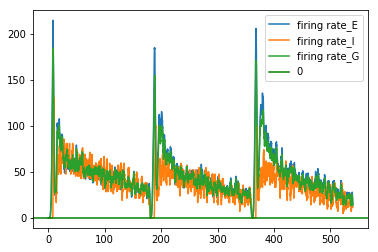

In [11]:
plot(ratemon_E.t/ms,ratemon_E.smooth_rate(window='flat', width=2*ms)/Hz,label="firing rate_E")
plot(ratemon_I.t/ms,ratemon_I.smooth_rate(window='flat', width=2*ms)/Hz,label="firing rate_I")
plot(ratemon_G.t/ms,ratemon_G.smooth_rate(window='flat', width=2*ms)/Hz,label="firing rate_G")

axhline(y=0,color="g",label="0")
legend()

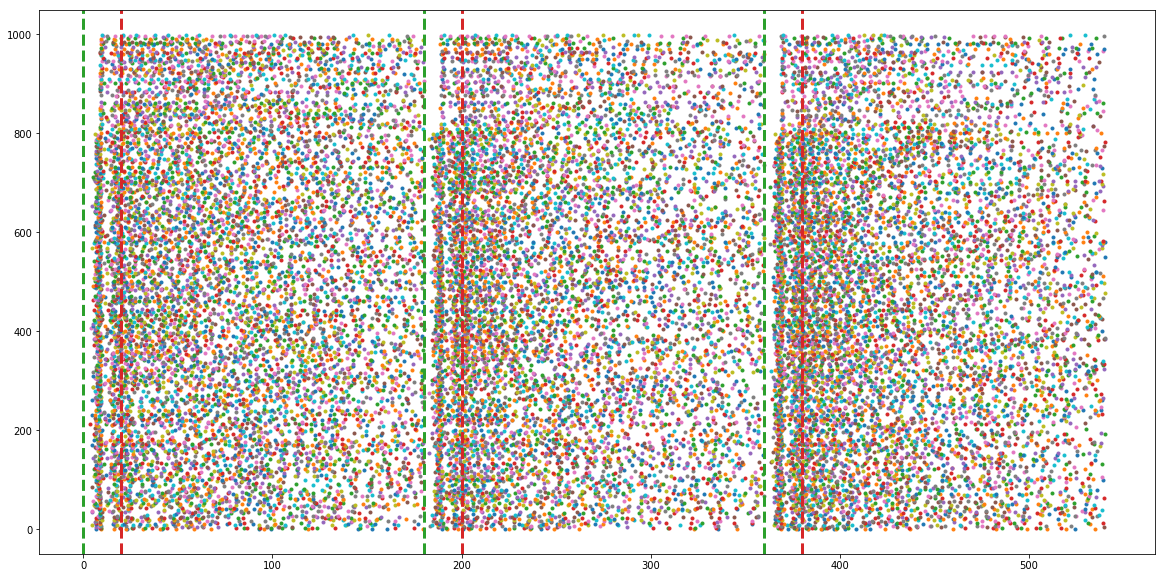

In [12]:
train=spikemon_G.spike_trains()
figure(figsize=(20,10))
for i in range(len(train)):
    plot(train[i]/ms,ones(len(train[i]))*i,'.')

for i in range(n_loop): #画出stim开始和结束的位置
    axvline(i*(sti_time+delay_time)/ms,ls='--', c='C2', lw=3)
    axvline((i*(sti_time+delay_time)+sti_time)/ms,ls='--', c='C3', lw=3)

# Test

In [13]:
s=0

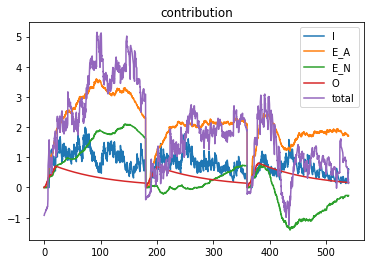

In [14]:
#contribution (the first neuron)
figure()
total=-statemon_G.v[s]+statemon_G_con_E_A.con_E_A[s]+statemon_G_con_E_N.con_E_N[s]-statemon_G_con_I.con_I[s]+statemon_G_con_O.con_O[s]
plot(statemon_G_con_I.t/ms, statemon_G_con_I.con_I[s], label='I')
plot(statemon_G_con_E_A.t/ms, statemon_G_con_E_A.con_E_A[s], label='E_A')
plot(statemon_G_con_E_N.t/ms, statemon_G_con_E_N.con_E_N[s], label='E_N')
plot(statemon_G_con_O.t/ms, statemon_G_con_O.con_O[s], label='O')
plot(statemon_G_con_O.t/ms,total,label="total")
# axvline(dec_time/ms, ls='--', c='C2', lw=3)
# axvline((dec_time+sti_time)/ms, ls='--', c='C2', lw=3)
plt.title("contribution")
legend()


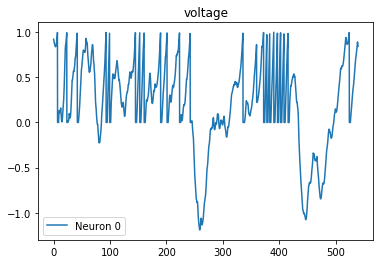

In [15]:
#voltage(主要看neuron0)
figure()
plot(statemon_G.t/ms, statemon_G.v[s], label='Neuron 0')
plt.title("voltage")
# axvline(dec_time/ms, ls='--', c='C2', lw=3)
# axvline((dec_time+sti_time)/ms, ls='--', c='C2', lw=3)
legend()
